# Imports

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pathlib import Path

# Dataset Listing and Loading

In [2]:
def read_data(path: Path):
    if path.suffix == ".csv":
        return pd.read_csv(path)
    else:                       # Excel
        return pd.read_excel(path)

- Dataset path:

In [3]:
DATA_DIR   = Path("datasets")          # CSV files
CSV_FILES  = sorted(DATA_DIR.glob("*.csv"))
assert CSV_FILES, "No CSV found"


- All avalable datasets:

In [4]:
for i, f in enumerate(CSV_FILES):
    print(i ,f.name)

0 abc3_oqmd_cs.csv
1 perov_form.csv
2 perov_stab.csv
3 vehicle1.csv
4 vehicle2.csv
5 wisconsin.csv


# Machine Learning Pipeline

## ML Model

In [5]:

CV         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CLASSIFIER = RandomForestClassifier(n_estimators=300,
                                    n_jobs=-1,
                                    random_state=42)


## Sampling Algorithms

In [6]:

SAMPLERS   = {
    "None"      : None,
    "SMOTE"     : SMOTE(random_state=42),
    "UpSample"  : RandomOverSampler(random_state=42),
    "DownSample": RandomUnderSampler(random_state=42),
}


## Model Metrics

In [7]:

METRICS    = ["accuracy", "macro_precision", "macro_recall", "macro_f1",
              "weighted_precision", "weighted_recall", "weighted_f1", "mcc"]

## Model Pipeline

In [8]:
def build_pipeline(sampler) -> ImbPipeline:
    steps = [
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),          # optional but cheap
    ]
    if sampler is not None:
        steps.append(("sample", sampler))
    steps.append(("clf", CLASSIFIER))
    return ImbPipeline(steps)

## Scoring function

In [9]:
def score_fold(y_true, y_pred) -> dict:
    return {
        "accuracy"          : accuracy_score(y_true, y_pred),
        "macro_precision"   : precision_score(y_true, y_pred,
                                              average="macro", zero_division=0),
        "macro_recall"      : recall_score(y_true, y_pred,
                                           average="macro", zero_division=0),
        "macro_f1"          : f1_score(y_true, y_pred,
                                       average="macro", zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred,
                                              average="weighted", zero_division=0),
        "weighted_recall"   : recall_score(y_true, y_pred,
                                           average="weighted", zero_division=0),
        "weighted_f1"       : f1_score(y_true, y_pred,
                                       average="weighted", zero_division=0),
        "mcc"               : matthews_corrcoef(y_true, y_pred),
    }

# Master loop – run pipelines

For all Datasets
- Loading Dataset
- Label Encoding
- Loop for all Sampling Algorithms
- Build Pipeline
- Train-Test model with StratifiedkFold
- Save the scores

In [10]:
scores = {m: {s: {} for s in SAMPLERS} for m in METRICS}   # metric -> sampler -> dataset -> score

for dataset_path in CSV_FILES:
    ds_name = dataset_path.stem
    print(f"\nProcessing {ds_name}" , end="\t\tSize = ")
    
    # load + basic cleaning
    df = read_data(dataset_path)
    print(df.shape, "\t", "No. of classes = ", df.iloc[:, -1].nunique())

    X = df.iloc[:, :-1].copy()
    y = LabelEncoder().fit_transform(df.iloc[:, -1])
    
    cat_cols = X.select_dtypes(exclude=np.number).columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    for samp_name, sampler in SAMPLERS.items():
        pipe = build_pipeline(sampler)
        fold_scores = {m: [] for m in METRICS}
        
        for train_idx, val_idx in CV.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            pipe.fit(X_train, y_train)          # ALL steps fitted only on train
            y_pred = pipe.predict(X_val)
            
            for k, v in score_fold(y_val, y_pred).items():
                fold_scores[k].append(v)
        
        # mean across folds
        for m in METRICS:
            scores[m][samp_name][ds_name] = np.mean(fold_scores[m])


Processing abc3_oqmd_cs		Size = (29209, 59) 	 No. of classes =  7

Processing perov_form		Size = (1505, 29) 	 No. of classes =  2

Processing perov_stab		Size = (3469, 29) 	 No. of classes =  2

Processing vehicle1		Size = (846, 19) 	 No. of classes =  2

Processing vehicle2		Size = (846, 19) 	 No. of classes =  2

Processing wisconsin		Size = (683, 10) 	 No. of classes =  2


# Results

- Scores

In [11]:
df_per_metric = []
for metric in METRICS:
    df = pd.DataFrame(scores[metric])#.T   # samplers × datasets
    # df = df.T                             # datasets × samplers
    df.name = metric
    df_per_metric.append(df)

- Display Scores

In [12]:
for df in df_per_metric:
    print("="*80)
    print(df.name)
    display(df)
    print("")

accuracy


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467
perov_form,0.926246,0.914950,0.913621,0.866445
perov_stab,0.935139,0.933699,0.935428,0.930815
vehicle1,0.794333,0.786022,0.791932,0.760090
vehicle2,0.985820,0.986996,0.986996,0.971612
wisconsin,0.973637,0.976567,0.973647,0.975118



macro_precision


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.890646,0.869960,0.877844,0.584143
perov_form,0.913819,0.879613,0.880652,0.799187
perov_stab,0.933442,0.931881,0.933494,0.928533
vehicle1,0.734721,0.723185,0.730208,0.724772
vehicle2,0.983178,0.983880,0.985350,0.955166
wisconsin,0.968825,0.970683,0.968102,0.968810



macro_recall


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.864475,0.873956,0.870073,0.759460
perov_form,0.857802,0.861018,0.854445,0.865786
perov_stab,0.935374,0.934394,0.936153,0.933105
vehicle1,0.691217,0.738290,0.733086,0.782797
vehicle2,0.979899,0.982224,0.980699,0.974814
wisconsin,0.973915,0.979042,0.974875,0.977963



macro_f1


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.876577,0.871510,0.873422,0.617315
perov_form,0.881557,0.869260,0.865826,0.822277
perov_stab,0.934237,0.932842,0.934587,0.930107
vehicle1,0.705212,0.728827,0.729671,0.729287
vehicle2,0.981356,0.982976,0.982856,0.963957
wisconsin,0.971158,0.974472,0.971253,0.972957



weighted_precision


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.902107,0.900131,0.900663,0.767757
perov_form,0.925060,0.913861,0.912194,0.891976
perov_stab,0.935621,0.934482,0.936088,0.932575
vehicle1,0.783243,0.795429,0.796182,0.823577
vehicle2,0.985981,0.987077,0.987114,0.973729
wisconsin,0.974128,0.977449,0.974257,0.976123



weighted_recall


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467
perov_form,0.926246,0.914950,0.913621,0.866445
perov_stab,0.935139,0.933699,0.935428,0.930815
vehicle1,0.794333,0.786022,0.791932,0.760090
vehicle2,0.985820,0.986996,0.986996,0.971612
wisconsin,0.973637,0.976567,0.973647,0.975118



weighted_f1


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.902380,0.900019,0.900710,0.723209
perov_form,0.923549,0.913872,0.912042,0.873433
perov_stab,0.935213,0.933801,0.935528,0.930999
vehicle1,0.783996,0.789422,0.792728,0.773291
vehicle2,0.985789,0.986991,0.986953,0.972010
wisconsin,0.973703,0.976677,0.973753,0.975257



mcc


,None,SMOTE,UpSample,DownSample
abc3_oqmd_cs,0.874381,0.870466,0.871479,0.635717
perov_form,0.769406,0.740114,0.734241,0.661487
perov_stab,0.868812,0.866270,0.869642,0.861625
vehicle1,0.423054,0.461027,0.462782,0.504186
vehicle2,0.963004,0.966074,0.965981,0.929636
wisconsin,0.942709,0.949671,0.942944,0.946713


# 7.  Bar-plots: % change vs SMOTE

- scores of SMOTE is set as baseline

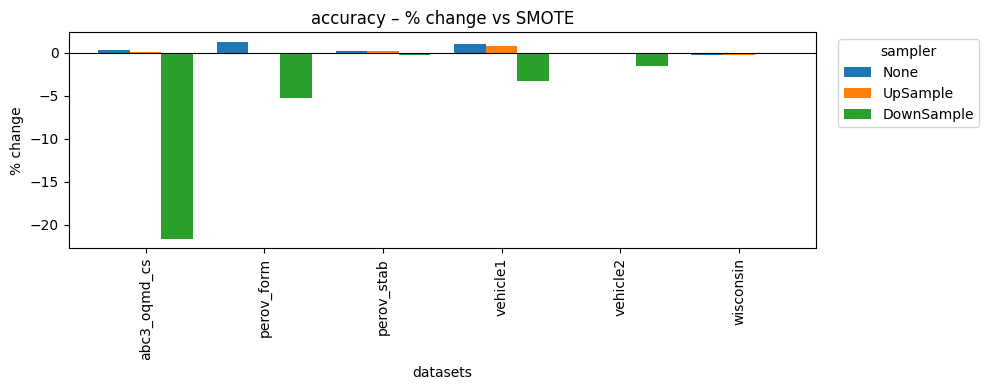

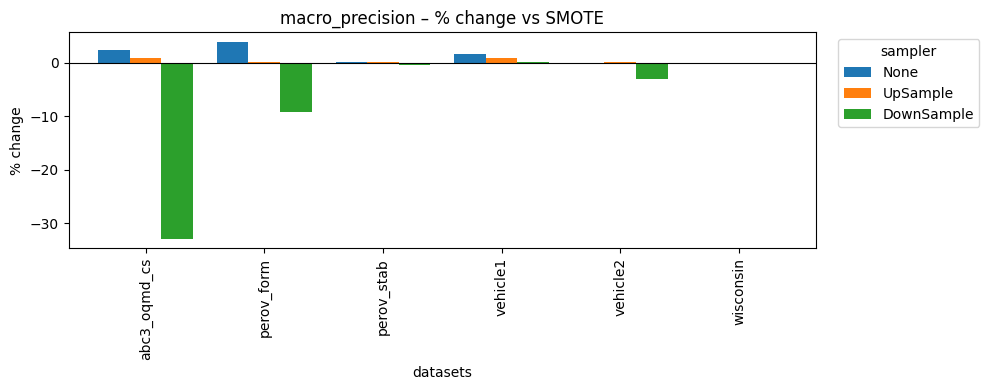

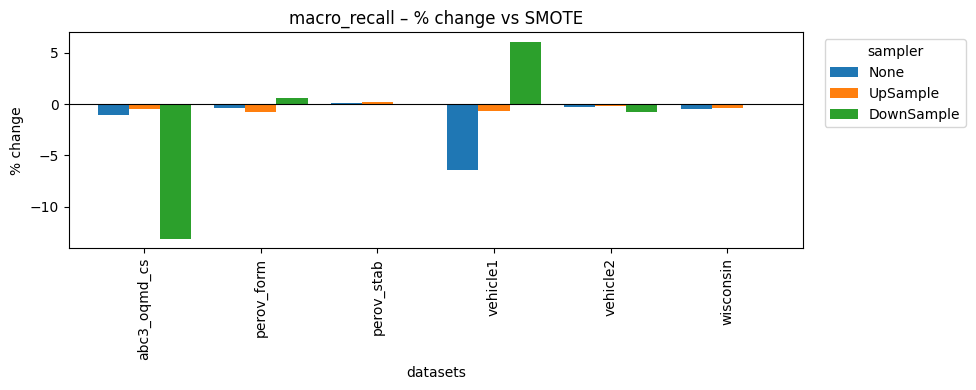

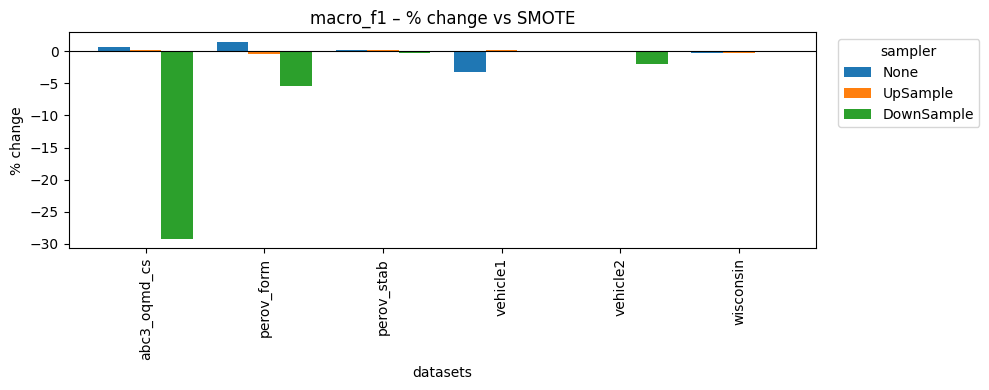

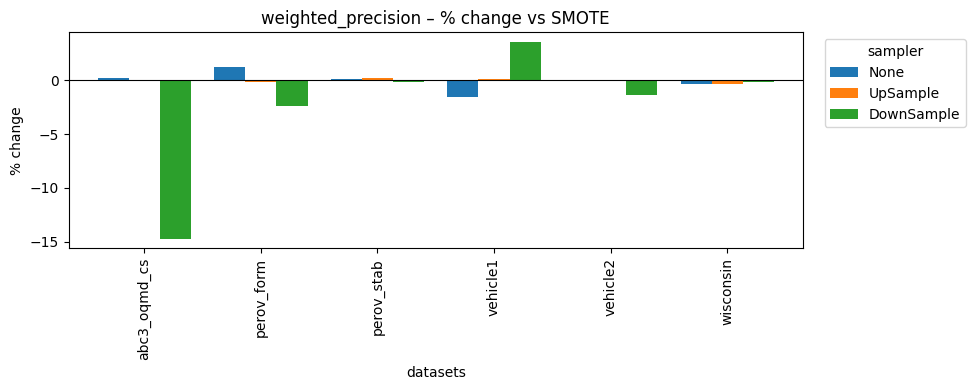

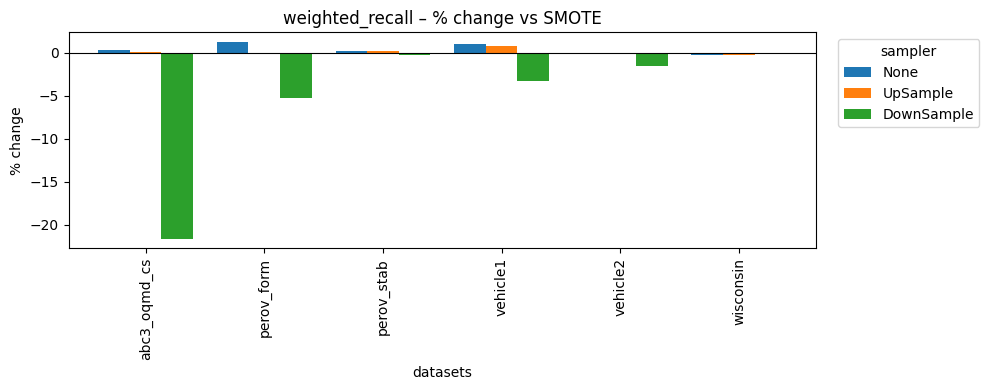

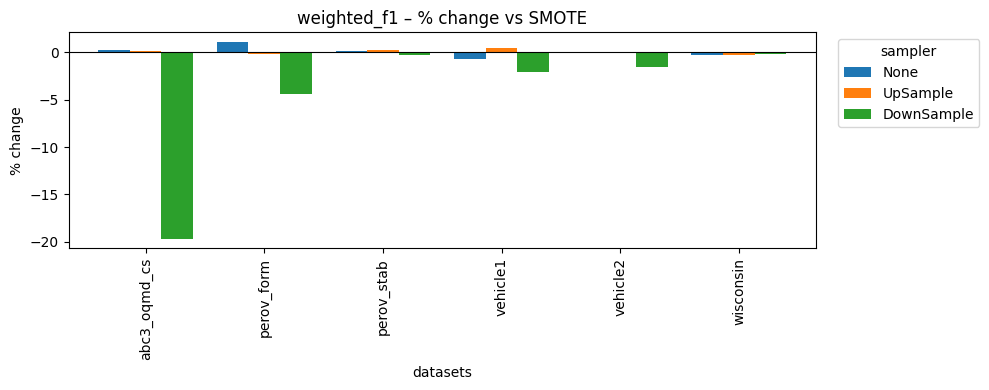

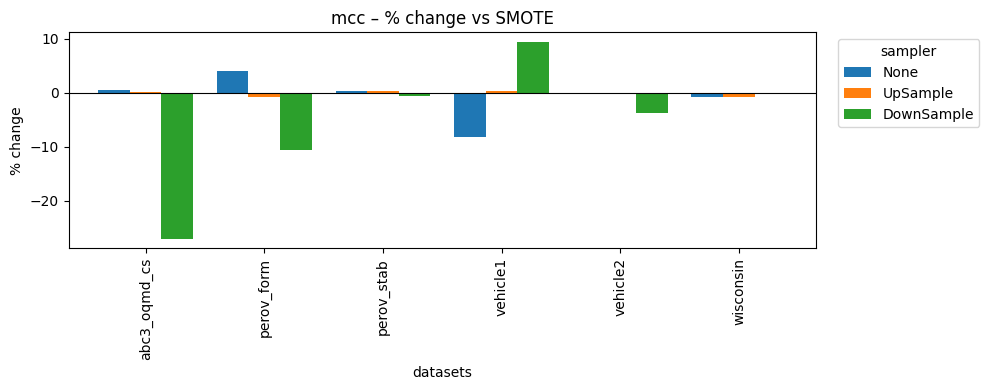

In [13]:
baseline = "SMOTE"
OUT_DIR = pathlib.Path("output"); OUT_DIR.mkdir(exist_ok=True)

for df in df_per_metric:
    metric = df.name
    rel = ((df.subtract(df[baseline], axis=0)
            .div(df[baseline], axis=0))*100).round(2)
    rel = rel.drop(columns=[baseline], errors="ignore")
    
    fig, ax = plt.subplots(figsize=(10, 4))
    rel.plot(kind="bar", ax=ax, width=0.8)
    ax.axhline(0, color="black", lw=0.8)
    ax.set_title(f"{metric} – % change vs SMOTE")
    ax.set_ylabel("% change"); ax.set_xlabel("datasets")
    ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    fig.savefig(OUT_DIR/f"rel_vs_smote_{metric}.png", dpi=300)
    plt.show()
    plt.close(fig)

# 8.  Export CSVs

In [14]:
for df in df_per_metric:
    df.to_csv(OUT_DIR/f"{df.name}.csv")

✅ **Completed**